# Import Libraries

In [1]:
import pandas as pd
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import json

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Load dataset and Image Paths

In [2]:
base_path = "/kaggle/input/body-img/bodym_dataset/"
image_folder_name = "mask"
target_col = "BodyFat_percent"
IMG_SIZE = 224
datasets = ["train", "testA", "testB"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download and prepare data

In [3]:
# for d in datasets:
#     file = os.path.join(base_path, d, "measurements_with_bodyfat.csv")
#     df = pd.read_csv(file)
    
#     df["BodyFat_percent"] = df["BodyFat_percent"] / 100.0
    
#     out_file = os.path.join(base_path, d, "measurements_with_bodyfat.csv")
#     df.to_csv(out_file, index=False)
    
#     print(f"{d} Done normalize body fat - {out_file}")

In [4]:
# تحميل وتجهيز البيانات
df_train_map = pd.read_csv(os.path.join(base_path, "train", "subject_to_photo_map.csv"))
df_train_meas = pd.read_csv(os.path.join(base_path, "train", "measurements_with_bodyfat.csv"))

# إعادة تسمية العمود الثاني إلى "image_name"
df_train_map = df_train_map.rename(columns={df_train_map.columns[1]: "image_name"})

# دمج البيانات
df_train = pd.merge(df_train_map, df_train_meas, on="subject_id", how="inner")

# إضافة امتداد الصور وبناء المسار
df_train["image_name"] = df_train["image_name"].apply(lambda x: str(x) + ".png")
df_train["image_path"] = df_train["image_name"].apply(lambda x: os.path.join(base_path, "train", image_folder_name, x))

# تصفية الصور الموجودة فقط
df_train = df_train[df_train["image_path"].apply(os.path.exists)].reset_index(drop=True)

print("Train DataFrame shape:", df_train.shape)
print(f"BodyFat_percent - Min: {df_train[target_col].min():.2f}, Max: {df_train[target_col].max():.2f}, Mean: {df_train[target_col].mean():.2f}")

Train DataFrame shape: (6134, 18)
BodyFat_percent - Min: 0.04, Max: 0.70, Mean: 0.19


# EDA 

### Summary Statistics

In [5]:
for d in datasets:
    df_map = pd.read_csv(os.path.join(base_path, d, "subject_to_photo_map.csv"))
    df_meas = pd.read_csv(os.path.join(base_path, d, "measurements_with_bodyfat.csv"))
    df = pd.merge(df_map, df_meas, on="subject_id", how="inner")
    
    print(f"=== {d} ===")
    print(df[target_col].describe())

=== train ===
count    6134.000000
mean        0.191965
std         0.079820
min         0.043662
25%         0.135571
50%         0.177859
75%         0.231446
max         0.699718
Name: BodyFat_percent, dtype: float64
=== testA ===
count    1684.000000
mean        0.179718
std         0.076220
min         0.065133
25%         0.117340
50%         0.171730
75%         0.222514
max         0.396125
Name: BodyFat_percent, dtype: float64
=== testB ===
count    1160.000000
mean        0.205806
std         0.081920
min         0.050054
25%         0.151078
50%         0.198893
75%         0.241781
max         0.522117
Name: BodyFat_percent, dtype: float64


### Histogram of BodyFat_percent

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


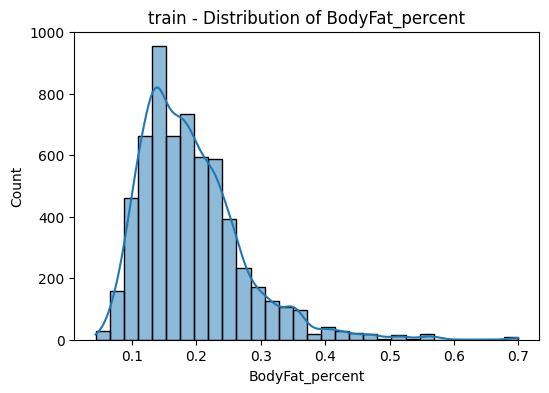

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


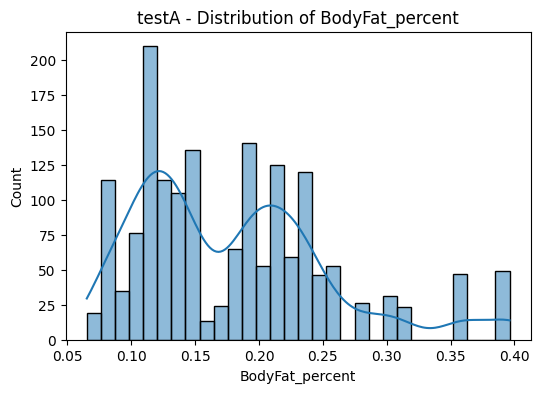

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


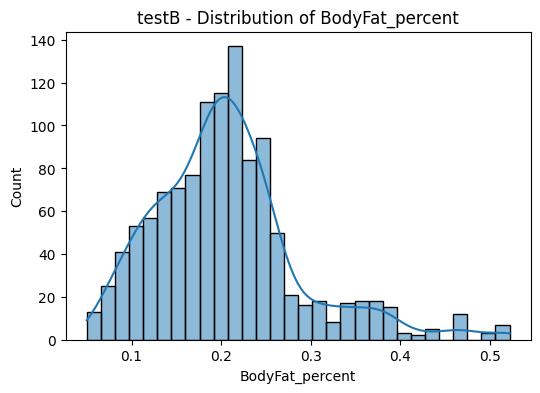

In [6]:
for d in datasets:
    df_map = pd.read_csv(os.path.join(base_path, d, "subject_to_photo_map.csv"))
    df_meas = pd.read_csv(os.path.join(base_path, d, "measurements_with_bodyfat.csv"))
    df = pd.merge(df_map, df_meas, on="subject_id", how="inner")
    
    plt.figure(figsize=(6,4))
    sns.histplot(df[target_col], bins=30, kde=True)
    plt.title(f"{d} - Distribution of {target_col}")
    plt.show()

### BodyFat_percent vs BMI

In [7]:
for d in datasets:
    df_map = pd.read_csv(os.path.join(base_path, d, "subject_to_photo_map.csv"))
    df_meas = pd.read_csv(os.path.join(base_path, d, "measurements_with_bodyfat.csv"))
    df = pd.merge(df_map, df_meas, on="subject_id", how="inner")
    
    if "BMI" in df.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x="BMI", y=target_col, data=df, hue="gender")
        plt.title(f"{d} - BodyFat_percent vs BMI")
        plt.show()

### Boxplot BodyFat_percent by Gender

In [8]:
for d in datasets:
    df_map = pd.read_csv(os.path.join(base_path, d, "subject_to_photo_map.csv"))
    df_meas = pd.read_csv(os.path.join(base_path, d, "measurements_with_bodyfat.csv"))
    df = pd.merge(df_map, df_meas, on="subject_id", how="inner")
    
    if "gender" in df.columns:
        plt.figure(figsize=(6,4))
        sns.boxplot(x="gender", y=target_col, data=df)
        plt.title(f"{d} - BodyFat_percent by Gender")
        plt.show()

### Correlation Heatmap

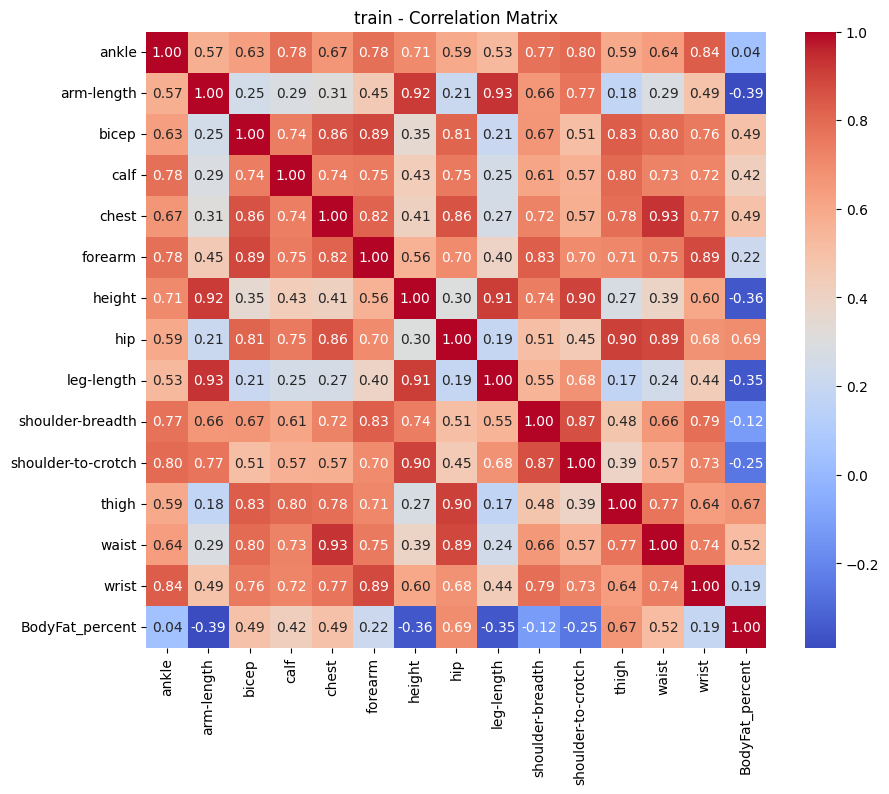

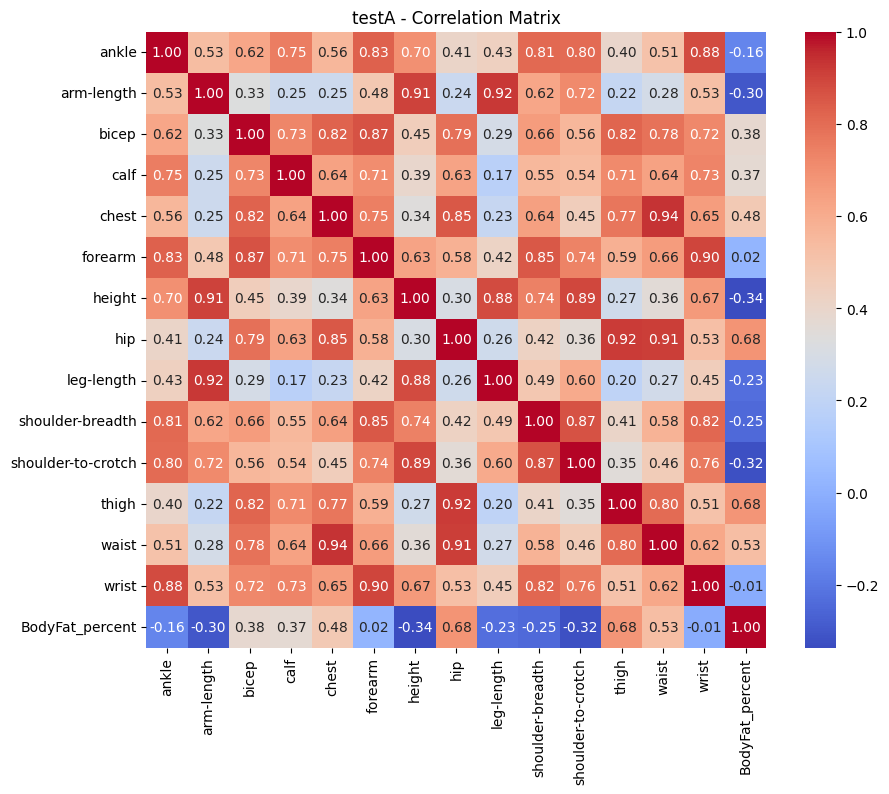

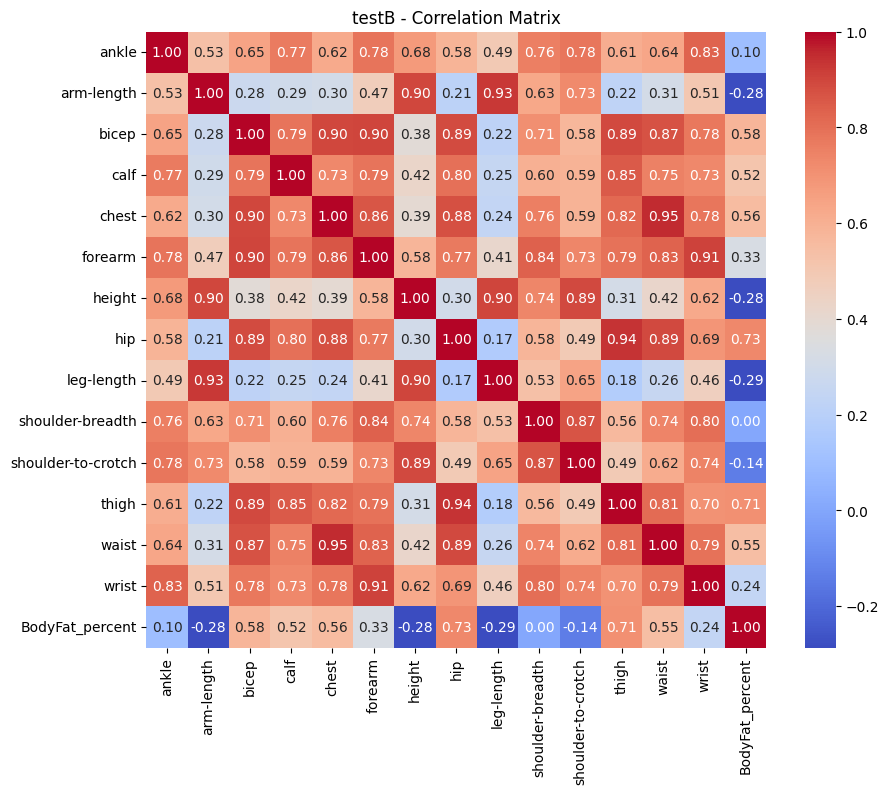

In [9]:
for d in datasets:
    df_map = pd.read_csv(os.path.join(base_path, d, "subject_to_photo_map.csv"))
    df_meas = pd.read_csv(os.path.join(base_path, d, "measurements_with_bodyfat.csv"))
    df = pd.merge(df_map, df_meas, on="subject_id", how="inner")
    
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"{d} - Correlation Matrix")
    plt.show()

# Transforms (Data Augmentation)

In [10]:
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.0, rotate_limit=25, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# Dataset & Dataloader (Dataset Class)

In [11]:
class BodyMDataset(Dataset):
    def __init__(self, df, target_col, transform=None):
        self.df = df.reset_index(drop=True)
        self.target_col = target_col
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row["image_path"], cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        if self.transform:
            img = self.transform(image=img)["image"]
            
        #prop
        p = np.float32(row[self.target_col])
        target_dist = np.array([p , 1.0 - p ], dtype=np.float32)
        return img, torch.tensor(target_dist)

# Data train and test splits

In [12]:
train_df, val_df = train_test_split(df_train, test_size=0.15, random_state=42)
train_ds = BodyMDataset(train_df, target_col, train_transform)
val_ds = BodyMDataset(val_df, target_col, valid_transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0)

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")

Training samples: 5213
Validation samples: 921


# Build EfficientNet B0 Model for Body Fat Prediction

### create model

In [13]:
class ImprovedBodyFatModel(nn.Module):
    def __init__(self, model_name='efficientnet_b2', pretrained=True):
        super().__init__()
        # backbone بدون
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        n_features = self.backbone.num_features
        
        
        self.classifier = nn.Sequential(
            nn.Linear(n_features, 2),
            nn.Softmax(dim=1)  
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

model = ImprovedBodyFatModel('efficientnet_b2', pretrained=True)
model = model.to(DEVICE)

print("Model created successfully!")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

Model created successfully!
Number of parameters: 7,703,812


###  Loss Function and Optimizer

In [14]:
class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.kl = nn.KLDivLoss(reduction='batchmean')
    
    def forward(self, y_pred, y_true):
        # نحول إلى log لأن KLDivLoss في PyTorch يتوقع log-probabilities
        y_pred_log = torch.log(torch.clamp(y_pred , 1e-9 , 1.0))
        
        return self.kl(y_pred_log, y_true)

In [15]:
criterion = KLDivergenceLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5, betas=(0.9,0.95))
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

### Improved functions to save all values

In [16]:
def train_epoch_with_metrics(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    all_preds = []
    all_targets = []
    
    for imgs, targets in tqdm(loader, desc="Training"):
        imgs = imgs.to(device).float()
        targets = targets.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item() * imgs.size(0)
        all_preds.append(outputs.detach().cpu().numpy())
        all_targets.append(targets.detach().cpu().numpy())
    
    all_preds = np.vstack(all_preds).squeeze()
    all_targets = np.vstack(all_targets).squeeze()
    
    train_mae = mean_absolute_error(all_targets, all_preds)
    train_rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    train_r2 = r2_score(all_targets, all_preds)
    avg_loss = running_loss / len(loader.dataset)
    
    return avg_loss, train_mae, train_rmse, train_r2, all_preds, all_targets


def validate_epoch(model, loader, device):
    model.eval()
    preds, trues = [], []
    running_loss = 0
    
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = imgs.to(device).float()
            targets = targets.to(device).float()
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * imgs.size(0)
            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())
    
    preds = np.vstack(preds).squeeze()
    trues = np.vstack(trues).squeeze()
    
    val_loss = running_loss / len(loader.dataset)
    mae = mean_absolute_error(trues, preds)
    rmse = np.sqrt(mean_squared_error(trues, preds))
    r2 = r2_score(trues, preds)
    
    return val_loss, mae, rmse, r2, preds, trues

print("Training functions defined!")

Training functions defined!


# Training Loop

In [17]:
EPOCHS = 150
best_rmse = float('inf')

total_steps = EPOCHS * len(train_loader)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=total_steps,   # number of scheduler steps
    eta_min=1e-6         # final LR
)


history = {
    'epoch': [],
    'train_loss': [],
    'train_mae': [],
    'train_rmse': [], 
    'train_r2': [],
    'val_loss': [],
    'val_mae': [],
    'val_rmse': [],
    'val_r2': [],
    'learning_rate': []
}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_mae, train_rmse, train_r2, train_preds, train_trues = train_epoch_with_metrics(
        model, train_loader, criterion, optimizer, DEVICE)
    
    val_loss, val_mae, val_rmse, val_r2, val_preds, val_trues = validate_epoch(model, val_loader, DEVICE)
    
    current_lr = optimizer.param_groups[0]['lr']
    
    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['train_mae'].append(train_mae)
    history['train_rmse'].append(train_rmse)
    history['train_r2'].append(train_r2)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)
    history['val_rmse'].append(val_rmse)
    history['val_r2'].append(val_r2)
    history['learning_rate'].append(current_lr)
    
    #scheduler.step(val_rmse)
    
    print(f"Epoch {epoch:02d}:")
    print(f"  Train - Loss: {train_loss:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
    print(f"  LR: {current_lr:.2e}")
    
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        torch.save(model.state_dict(), "best_model.pth")
        torch.save(model, "best_model.pkl")
        print("Saved best model as .pth and .pkl!")

Training: 100%|██████████| 326/326 [01:18<00:00,  4.16it/s]


Epoch 01:
  Train - Loss: 0.0095, MAE: 0.0401, RMSE: 0.0558, R²: 0.5124
  Val   - Loss: 0.0042, MAE: 0.0276, RMSE: 0.0355, R²: 0.7993
  LR: 1.00e-04
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:03<00:00,  5.14it/s]


Epoch 02:
  Train - Loss: 0.0045, MAE: 0.0287, RMSE: 0.0370, R²: 0.7855
  Val   - Loss: 0.0038, MAE: 0.0272, RMSE: 0.0341, R²: 0.8144
  LR: 1.00e-04
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:04<00:00,  5.05it/s]


Epoch 03:
  Train - Loss: 0.0035, MAE: 0.0251, RMSE: 0.0325, R²: 0.8345
  Val   - Loss: 0.0045, MAE: 0.0275, RMSE: 0.0345, R²: 0.8099
  LR: 9.99e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.04it/s]


Epoch 04:
  Train - Loss: 0.0029, MAE: 0.0224, RMSE: 0.0295, R²: 0.8642
  Val   - Loss: 0.0027, MAE: 0.0226, RMSE: 0.0287, R²: 0.8682
  LR: 9.98e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:04<00:00,  5.03it/s]


Epoch 05:
  Train - Loss: 0.0024, MAE: 0.0204, RMSE: 0.0270, R²: 0.8856
  Val   - Loss: 0.0030, MAE: 0.0243, RMSE: 0.0298, R²: 0.8584
  LR: 9.97e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 06:
  Train - Loss: 0.0021, MAE: 0.0190, RMSE: 0.0250, R²: 0.9020
  Val   - Loss: 0.0020, MAE: 0.0194, RMSE: 0.0252, R²: 0.8990
  LR: 9.96e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:05<00:00,  4.97it/s]


Epoch 07:
  Train - Loss: 0.0019, MAE: 0.0183, RMSE: 0.0243, R²: 0.9079
  Val   - Loss: 0.0024, MAE: 0.0202, RMSE: 0.0269, R²: 0.8845
  LR: 9.95e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 08:
  Train - Loss: 0.0018, MAE: 0.0174, RMSE: 0.0234, R²: 0.9146
  Val   - Loss: 0.0017, MAE: 0.0168, RMSE: 0.0226, R²: 0.9184
  LR: 9.93e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:05<00:00,  4.97it/s]


Epoch 09:
  Train - Loss: 0.0015, MAE: 0.0161, RMSE: 0.0214, R²: 0.9281
  Val   - Loss: 0.0022, MAE: 0.0203, RMSE: 0.0261, R²: 0.8911
  LR: 9.91e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.96it/s]


Epoch 10:
  Train - Loss: 0.0015, MAE: 0.0160, RMSE: 0.0215, R²: 0.9276
  Val   - Loss: 0.0015, MAE: 0.0154, RMSE: 0.0214, R²: 0.9271
  LR: 9.89e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:06<00:00,  4.94it/s]


Epoch 11:
  Train - Loss: 0.0014, MAE: 0.0154, RMSE: 0.0206, R²: 0.9337
  Val   - Loss: 0.0033, MAE: 0.0229, RMSE: 0.0294, R²: 0.8616
  LR: 9.87e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 12:
  Train - Loss: 0.0014, MAE: 0.0150, RMSE: 0.0201, R²: 0.9365
  Val   - Loss: 0.0024, MAE: 0.0210, RMSE: 0.0280, R²: 0.8745
  LR: 9.84e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 13:
  Train - Loss: 0.0013, MAE: 0.0146, RMSE: 0.0196, R²: 0.9401
  Val   - Loss: 0.0028, MAE: 0.0238, RMSE: 0.0286, R²: 0.8695
  LR: 9.82e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.91it/s]


Epoch 14:
  Train - Loss: 0.0012, MAE: 0.0140, RMSE: 0.0190, R²: 0.9436
  Val   - Loss: 0.0025, MAE: 0.0215, RMSE: 0.0269, R²: 0.8844
  LR: 9.79e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.92it/s]


Epoch 15:
  Train - Loss: 0.0011, MAE: 0.0132, RMSE: 0.0181, R²: 0.9487
  Val   - Loss: 0.0015, MAE: 0.0148, RMSE: 0.0211, R²: 0.9291
  LR: 9.76e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:07<00:00,  4.86it/s]


Epoch 16:
  Train - Loss: 0.0010, MAE: 0.0128, RMSE: 0.0173, R²: 0.9533
  Val   - Loss: 0.0016, MAE: 0.0155, RMSE: 0.0216, R²: 0.9256
  LR: 9.72e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.95it/s]


Epoch 17:
  Train - Loss: 0.0010, MAE: 0.0126, RMSE: 0.0171, R²: 0.9541
  Val   - Loss: 0.0013, MAE: 0.0139, RMSE: 0.0195, R²: 0.9395
  LR: 9.69e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:06<00:00,  4.93it/s]


Epoch 18:
  Train - Loss: 0.0010, MAE: 0.0126, RMSE: 0.0173, R²: 0.9533
  Val   - Loss: 0.0016, MAE: 0.0166, RMSE: 0.0220, R²: 0.9227
  LR: 9.65e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.94it/s]


Epoch 19:
  Train - Loss: 0.0009, MAE: 0.0117, RMSE: 0.0162, R²: 0.9587
  Val   - Loss: 0.0011, MAE: 0.0134, RMSE: 0.0182, R²: 0.9471
  LR: 9.61e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:06<00:00,  4.93it/s]


Epoch 20:
  Train - Loss: 0.0009, MAE: 0.0118, RMSE: 0.0162, R²: 0.9589
  Val   - Loss: 0.0012, MAE: 0.0135, RMSE: 0.0187, R²: 0.9444
  LR: 9.57e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.96it/s]


Epoch 21:
  Train - Loss: 0.0008, MAE: 0.0116, RMSE: 0.0159, R²: 0.9603
  Val   - Loss: 0.0021, MAE: 0.0197, RMSE: 0.0249, R²: 0.9014
  LR: 9.53e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.91it/s]


Epoch 22:
  Train - Loss: 0.0008, MAE: 0.0115, RMSE: 0.0158, R²: 0.9611
  Val   - Loss: 0.0012, MAE: 0.0134, RMSE: 0.0187, R²: 0.9440
  LR: 9.48e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.94it/s]


Epoch 23:
  Train - Loss: 0.0008, MAE: 0.0111, RMSE: 0.0151, R²: 0.9643
  Val   - Loss: 0.0012, MAE: 0.0135, RMSE: 0.0187, R²: 0.9443
  LR: 9.44e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s]


Epoch 24:
  Train - Loss: 0.0008, MAE: 0.0111, RMSE: 0.0151, R²: 0.9642
  Val   - Loss: 0.0012, MAE: 0.0137, RMSE: 0.0190, R²: 0.9422
  LR: 9.39e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.87it/s]


Epoch 25:
  Train - Loss: 0.0007, MAE: 0.0108, RMSE: 0.0148, R²: 0.9656
  Val   - Loss: 0.0012, MAE: 0.0142, RMSE: 0.0197, R²: 0.9380
  LR: 9.34e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.92it/s]


Epoch 26:
  Train - Loss: 0.0007, MAE: 0.0106, RMSE: 0.0144, R²: 0.9677
  Val   - Loss: 0.0013, MAE: 0.0151, RMSE: 0.0198, R²: 0.9375
  LR: 9.28e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.95it/s]


Epoch 27:
  Train - Loss: 0.0007, MAE: 0.0104, RMSE: 0.0145, R²: 0.9669
  Val   - Loss: 0.0013, MAE: 0.0150, RMSE: 0.0199, R²: 0.9369
  LR: 9.23e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.97it/s]


Epoch 28:
  Train - Loss: 0.0007, MAE: 0.0101, RMSE: 0.0140, R²: 0.9694
  Val   - Loss: 0.0011, MAE: 0.0131, RMSE: 0.0177, R²: 0.9498
  LR: 9.17e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:06<00:00,  4.88it/s]


Epoch 29:
  Train - Loss: 0.0006, MAE: 0.0099, RMSE: 0.0135, R²: 0.9714
  Val   - Loss: 0.0011, MAE: 0.0137, RMSE: 0.0185, R²: 0.9452
  LR: 9.11e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 30:
  Train - Loss: 0.0006, MAE: 0.0094, RMSE: 0.0129, R²: 0.9739
  Val   - Loss: 0.0011, MAE: 0.0134, RMSE: 0.0182, R²: 0.9472
  LR: 9.05e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 31:
  Train - Loss: 0.0005, MAE: 0.0092, RMSE: 0.0130, R²: 0.9734
  Val   - Loss: 0.0009, MAE: 0.0118, RMSE: 0.0167, R²: 0.9555
  LR: 8.99e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 32:
  Train - Loss: 0.0005, MAE: 0.0092, RMSE: 0.0128, R²: 0.9745
  Val   - Loss: 0.0010, MAE: 0.0121, RMSE: 0.0170, R²: 0.9536
  LR: 8.93e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 33:
  Train - Loss: 0.0006, MAE: 0.0094, RMSE: 0.0133, R²: 0.9725
  Val   - Loss: 0.0012, MAE: 0.0138, RMSE: 0.0186, R²: 0.9450
  LR: 8.86e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 34:
  Train - Loss: 0.0005, MAE: 0.0090, RMSE: 0.0127, R²: 0.9747
  Val   - Loss: 0.0010, MAE: 0.0124, RMSE: 0.0171, R²: 0.9533
  LR: 8.80e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 35:
  Train - Loss: 0.0005, MAE: 0.0088, RMSE: 0.0123, R²: 0.9762
  Val   - Loss: 0.0012, MAE: 0.0146, RMSE: 0.0189, R²: 0.9428
  LR: 8.73e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.98it/s]


Epoch 36:
  Train - Loss: 0.0005, MAE: 0.0084, RMSE: 0.0118, R²: 0.9783
  Val   - Loss: 0.0009, MAE: 0.0122, RMSE: 0.0168, R²: 0.9551
  LR: 8.66e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 37:
  Train - Loss: 0.0005, MAE: 0.0088, RMSE: 0.0125, R²: 0.9756
  Val   - Loss: 0.0013, MAE: 0.0145, RMSE: 0.0192, R²: 0.9413
  LR: 8.59e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 38:
  Train - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0120, R²: 0.9774
  Val   - Loss: 0.0013, MAE: 0.0149, RMSE: 0.0199, R²: 0.9368
  LR: 8.51e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 39:
  Train - Loss: 0.0004, MAE: 0.0082, RMSE: 0.0112, R²: 0.9803
  Val   - Loss: 0.0009, MAE: 0.0113, RMSE: 0.0161, R²: 0.9585
  LR: 8.44e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 40:
  Train - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0121, R²: 0.9771
  Val   - Loss: 0.0009, MAE: 0.0117, RMSE: 0.0163, R²: 0.9576
  LR: 8.36e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.96it/s]


Epoch 41:
  Train - Loss: 0.0004, MAE: 0.0080, RMSE: 0.0110, R²: 0.9812
  Val   - Loss: 0.0010, MAE: 0.0127, RMSE: 0.0171, R²: 0.9531
  LR: 8.28e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 42:
  Train - Loss: 0.0005, MAE: 0.0082, RMSE: 0.0116, R²: 0.9790
  Val   - Loss: 0.0010, MAE: 0.0117, RMSE: 0.0167, R²: 0.9557
  LR: 8.21e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 43:
  Train - Loss: 0.0004, MAE: 0.0079, RMSE: 0.0112, R²: 0.9804
  Val   - Loss: 0.0009, MAE: 0.0121, RMSE: 0.0164, R²: 0.9568
  LR: 8.12e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.04it/s]


Epoch 44:
  Train - Loss: 0.0004, MAE: 0.0078, RMSE: 0.0111, R²: 0.9808
  Val   - Loss: 0.0008, MAE: 0.0116, RMSE: 0.0159, R²: 0.9597
  LR: 8.04e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 45:
  Train - Loss: 0.0004, MAE: 0.0077, RMSE: 0.0109, R²: 0.9815
  Val   - Loss: 0.0009, MAE: 0.0116, RMSE: 0.0159, R²: 0.9599
  LR: 7.96e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 46:
  Train - Loss: 0.0004, MAE: 0.0079, RMSE: 0.0109, R²: 0.9813
  Val   - Loss: 0.0009, MAE: 0.0116, RMSE: 0.0159, R²: 0.9595
  LR: 7.88e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 47:
  Train - Loss: 0.0004, MAE: 0.0075, RMSE: 0.0107, R²: 0.9820
  Val   - Loss: 0.0008, MAE: 0.0111, RMSE: 0.0157, R²: 0.9605
  LR: 7.79e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 48:
  Train - Loss: 0.0004, MAE: 0.0075, RMSE: 0.0108, R²: 0.9818
  Val   - Loss: 0.0008, MAE: 0.0113, RMSE: 0.0159, R²: 0.9598
  LR: 7.70e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.95it/s]


Epoch 49:
  Train - Loss: 0.0003, MAE: 0.0072, RMSE: 0.0101, R²: 0.9841
  Val   - Loss: 0.0008, MAE: 0.0114, RMSE: 0.0157, R²: 0.9609
  LR: 7.61e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:04<00:00,  5.03it/s]


Epoch 50:
  Train - Loss: 0.0003, MAE: 0.0072, RMSE: 0.0102, R²: 0.9837
  Val   - Loss: 0.0012, MAE: 0.0138, RMSE: 0.0186, R²: 0.9446
  LR: 7.53e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.97it/s]


Epoch 51:
  Train - Loss: 0.0003, MAE: 0.0069, RMSE: 0.0096, R²: 0.9856
  Val   - Loss: 0.0009, MAE: 0.0118, RMSE: 0.0163, R²: 0.9575
  LR: 7.43e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.03it/s]


Epoch 52:
  Train - Loss: 0.0003, MAE: 0.0068, RMSE: 0.0099, R²: 0.9848
  Val   - Loss: 0.0009, MAE: 0.0116, RMSE: 0.0164, R²: 0.9569
  LR: 7.34e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 53:
  Train - Loss: 0.0003, MAE: 0.0066, RMSE: 0.0094, R²: 0.9862
  Val   - Loss: 0.0008, MAE: 0.0113, RMSE: 0.0158, R²: 0.9603
  LR: 7.25e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 54:
  Train - Loss: 0.0003, MAE: 0.0067, RMSE: 0.0098, R²: 0.9851
  Val   - Loss: 0.0008, MAE: 0.0110, RMSE: 0.0154, R²: 0.9622
  LR: 7.16e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s]


Epoch 55:
  Train - Loss: 0.0003, MAE: 0.0066, RMSE: 0.0092, R²: 0.9869
  Val   - Loss: 0.0009, MAE: 0.0116, RMSE: 0.0169, R²: 0.9544
  LR: 7.06e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.87it/s]


Epoch 56:
  Train - Loss: 0.0003, MAE: 0.0067, RMSE: 0.0096, R²: 0.9855
  Val   - Loss: 0.0007, MAE: 0.0103, RMSE: 0.0147, R²: 0.9654
  LR: 6.97e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:07<00:00,  4.82it/s]


Epoch 57:
  Train - Loss: 0.0003, MAE: 0.0066, RMSE: 0.0093, R²: 0.9865
  Val   - Loss: 0.0008, MAE: 0.0114, RMSE: 0.0160, R²: 0.9593
  LR: 6.87e-05


Training: 100%|██████████| 326/326 [01:07<00:00,  4.83it/s]


Epoch 58:
  Train - Loss: 0.0003, MAE: 0.0065, RMSE: 0.0090, R²: 0.9873
  Val   - Loss: 0.0015, MAE: 0.0171, RMSE: 0.0211, R²: 0.9286
  LR: 6.78e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 59:
  Train - Loss: 0.0002, MAE: 0.0061, RMSE: 0.0086, R²: 0.9885
  Val   - Loss: 0.0007, MAE: 0.0106, RMSE: 0.0151, R²: 0.9635
  LR: 6.68e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.03it/s]


Epoch 60:
  Train - Loss: 0.0003, MAE: 0.0062, RMSE: 0.0088, R²: 0.9877
  Val   - Loss: 0.0007, MAE: 0.0105, RMSE: 0.0149, R²: 0.9645
  LR: 6.58e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 61:
  Train - Loss: 0.0002, MAE: 0.0060, RMSE: 0.0085, R²: 0.9886
  Val   - Loss: 0.0007, MAE: 0.0102, RMSE: 0.0145, R²: 0.9665
  LR: 6.48e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:04<00:00,  5.03it/s]


Epoch 62:
  Train - Loss: 0.0002, MAE: 0.0060, RMSE: 0.0086, R²: 0.9884
  Val   - Loss: 0.0007, MAE: 0.0104, RMSE: 0.0150, R²: 0.9642
  LR: 6.38e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.03it/s]


Epoch 63:
  Train - Loss: 0.0002, MAE: 0.0058, RMSE: 0.0082, R²: 0.9895
  Val   - Loss: 0.0007, MAE: 0.0104, RMSE: 0.0148, R²: 0.9649
  LR: 6.28e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 64:
  Train - Loss: 0.0002, MAE: 0.0058, RMSE: 0.0081, R²: 0.9898
  Val   - Loss: 0.0007, MAE: 0.0103, RMSE: 0.0149, R²: 0.9646
  LR: 6.18e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.94it/s]


Epoch 65:
  Train - Loss: 0.0002, MAE: 0.0058, RMSE: 0.0084, R²: 0.9889
  Val   - Loss: 0.0008, MAE: 0.0114, RMSE: 0.0156, R²: 0.9613
  LR: 6.08e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.94it/s]


Epoch 66:
  Train - Loss: 0.0002, MAE: 0.0059, RMSE: 0.0084, R²: 0.9890
  Val   - Loss: 0.0007, MAE: 0.0099, RMSE: 0.0141, R²: 0.9682
  LR: 5.98e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:05<00:00,  4.95it/s]


Epoch 67:
  Train - Loss: 0.0002, MAE: 0.0058, RMSE: 0.0082, R²: 0.9896
  Val   - Loss: 0.0008, MAE: 0.0111, RMSE: 0.0153, R²: 0.9629
  LR: 5.88e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.95it/s]


Epoch 68:
  Train - Loss: 0.0002, MAE: 0.0057, RMSE: 0.0081, R²: 0.9897
  Val   - Loss: 0.0009, MAE: 0.0123, RMSE: 0.0162, R²: 0.9581
  LR: 5.77e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.97it/s]


Epoch 69:
  Train - Loss: 0.0002, MAE: 0.0054, RMSE: 0.0076, R²: 0.9909
  Val   - Loss: 0.0007, MAE: 0.0103, RMSE: 0.0147, R²: 0.9656
  LR: 5.67e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.95it/s]


Epoch 70:
  Train - Loss: 0.0002, MAE: 0.0053, RMSE: 0.0078, R²: 0.9905
  Val   - Loss: 0.0008, MAE: 0.0109, RMSE: 0.0157, R²: 0.9604
  LR: 5.57e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.95it/s]


Epoch 71:
  Train - Loss: 0.0002, MAE: 0.0055, RMSE: 0.0079, R²: 0.9903
  Val   - Loss: 0.0007, MAE: 0.0100, RMSE: 0.0143, R²: 0.9676
  LR: 5.46e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.96it/s]


Epoch 72:
  Train - Loss: 0.0002, MAE: 0.0054, RMSE: 0.0079, R²: 0.9902
  Val   - Loss: 0.0007, MAE: 0.0097, RMSE: 0.0139, R²: 0.9690
  LR: 5.36e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:05<00:00,  4.94it/s]


Epoch 73:
  Train - Loss: 0.0002, MAE: 0.0053, RMSE: 0.0075, R²: 0.9911
  Val   - Loss: 0.0006, MAE: 0.0098, RMSE: 0.0140, R²: 0.9689
  LR: 5.26e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.91it/s]


Epoch 74:
  Train - Loss: 0.0002, MAE: 0.0051, RMSE: 0.0071, R²: 0.9920
  Val   - Loss: 0.0006, MAE: 0.0094, RMSE: 0.0138, R²: 0.9698
  LR: 5.15e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:06<00:00,  4.89it/s]


Epoch 75:
  Train - Loss: 0.0002, MAE: 0.0051, RMSE: 0.0071, R²: 0.9921
  Val   - Loss: 0.0007, MAE: 0.0098, RMSE: 0.0144, R²: 0.9670
  LR: 5.05e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.91it/s]


Epoch 76:
  Train - Loss: 0.0002, MAE: 0.0050, RMSE: 0.0070, R²: 0.9924
  Val   - Loss: 0.0008, MAE: 0.0112, RMSE: 0.0154, R²: 0.9623
  LR: 4.95e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.97it/s]


Epoch 77:
  Train - Loss: 0.0002, MAE: 0.0050, RMSE: 0.0070, R²: 0.9923
  Val   - Loss: 0.0006, MAE: 0.0098, RMSE: 0.0141, R²: 0.9684
  LR: 4.84e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.97it/s]


Epoch 78:
  Train - Loss: 0.0002, MAE: 0.0049, RMSE: 0.0070, R²: 0.9924
  Val   - Loss: 0.0006, MAE: 0.0099, RMSE: 0.0139, R²: 0.9692
  LR: 4.74e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 79:
  Train - Loss: 0.0002, MAE: 0.0049, RMSE: 0.0069, R²: 0.9925
  Val   - Loss: 0.0007, MAE: 0.0098, RMSE: 0.0140, R²: 0.9687
  LR: 4.64e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 80:
  Train - Loss: 0.0001, MAE: 0.0046, RMSE: 0.0064, R²: 0.9936
  Val   - Loss: 0.0006, MAE: 0.0096, RMSE: 0.0138, R²: 0.9695
  LR: 4.53e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 81:
  Train - Loss: 0.0002, MAE: 0.0047, RMSE: 0.0068, R²: 0.9928
  Val   - Loss: 0.0007, MAE: 0.0097, RMSE: 0.0142, R²: 0.9678
  LR: 4.43e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 82:
  Train - Loss: 0.0002, MAE: 0.0047, RMSE: 0.0068, R²: 0.9927
  Val   - Loss: 0.0007, MAE: 0.0101, RMSE: 0.0144, R²: 0.9669
  LR: 4.33e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.98it/s]


Epoch 83:
  Train - Loss: 0.0001, MAE: 0.0044, RMSE: 0.0062, R²: 0.9940
  Val   - Loss: 0.0006, MAE: 0.0094, RMSE: 0.0134, R²: 0.9715
  LR: 4.22e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 84:
  Train - Loss: 0.0001, MAE: 0.0046, RMSE: 0.0065, R²: 0.9934
  Val   - Loss: 0.0006, MAE: 0.0096, RMSE: 0.0136, R²: 0.9705
  LR: 4.12e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 85:
  Train - Loss: 0.0001, MAE: 0.0044, RMSE: 0.0063, R²: 0.9938
  Val   - Loss: 0.0006, MAE: 0.0096, RMSE: 0.0137, R²: 0.9699
  LR: 4.02e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.97it/s]


Epoch 86:
  Train - Loss: 0.0001, MAE: 0.0044, RMSE: 0.0061, R²: 0.9942
  Val   - Loss: 0.0006, MAE: 0.0098, RMSE: 0.0138, R²: 0.9696
  LR: 3.92e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.95it/s]


Epoch 87:
  Train - Loss: 0.0001, MAE: 0.0044, RMSE: 0.0061, R²: 0.9942
  Val   - Loss: 0.0006, MAE: 0.0095, RMSE: 0.0135, R²: 0.9710
  LR: 3.82e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.97it/s]


Epoch 88:
  Train - Loss: 0.0001, MAE: 0.0042, RMSE: 0.0060, R²: 0.9943
  Val   - Loss: 0.0007, MAE: 0.0100, RMSE: 0.0145, R²: 0.9665
  LR: 3.72e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.98it/s]


Epoch 89:
  Train - Loss: 0.0001, MAE: 0.0042, RMSE: 0.0060, R²: 0.9944
  Val   - Loss: 0.0006, MAE: 0.0094, RMSE: 0.0137, R²: 0.9700
  LR: 3.62e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 90:
  Train - Loss: 0.0001, MAE: 0.0042, RMSE: 0.0060, R²: 0.9944
  Val   - Loss: 0.0006, MAE: 0.0092, RMSE: 0.0138, R²: 0.9698
  LR: 3.52e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.97it/s]


Epoch 91:
  Train - Loss: 0.0001, MAE: 0.0041, RMSE: 0.0058, R²: 0.9948
  Val   - Loss: 0.0006, MAE: 0.0092, RMSE: 0.0137, R²: 0.9703
  LR: 3.42e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.03it/s]


Epoch 92:
  Train - Loss: 0.0001, MAE: 0.0041, RMSE: 0.0058, R²: 0.9947
  Val   - Loss: 0.0006, MAE: 0.0094, RMSE: 0.0134, R²: 0.9715
  LR: 3.32e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 93:
  Train - Loss: 0.0001, MAE: 0.0040, RMSE: 0.0056, R²: 0.9951
  Val   - Loss: 0.0006, MAE: 0.0091, RMSE: 0.0136, R²: 0.9705
  LR: 3.23e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.90it/s]


Epoch 94:
  Train - Loss: 0.0001, MAE: 0.0041, RMSE: 0.0059, R²: 0.9945
  Val   - Loss: 0.0006, MAE: 0.0095, RMSE: 0.0135, R²: 0.9709
  LR: 3.13e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 95:
  Train - Loss: 0.0001, MAE: 0.0040, RMSE: 0.0056, R²: 0.9951
  Val   - Loss: 0.0006, MAE: 0.0090, RMSE: 0.0132, R²: 0.9722
  LR: 3.04e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:05<00:00,  4.98it/s]


Epoch 96:
  Train - Loss: 0.0001, MAE: 0.0039, RMSE: 0.0055, R²: 0.9953
  Val   - Loss: 0.0006, MAE: 0.0096, RMSE: 0.0136, R²: 0.9705
  LR: 2.94e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.96it/s]


Epoch 97:
  Train - Loss: 0.0001, MAE: 0.0038, RMSE: 0.0056, R²: 0.9950
  Val   - Loss: 0.0006, MAE: 0.0088, RMSE: 0.0130, R²: 0.9730
  LR: 2.85e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:04<00:00,  5.03it/s]


Epoch 98:
  Train - Loss: 0.0001, MAE: 0.0037, RMSE: 0.0052, R²: 0.9958
  Val   - Loss: 0.0006, MAE: 0.0089, RMSE: 0.0131, R²: 0.9725
  LR: 2.76e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 99:
  Train - Loss: 0.0001, MAE: 0.0037, RMSE: 0.0054, R²: 0.9955
  Val   - Loss: 0.0006, MAE: 0.0088, RMSE: 0.0129, R²: 0.9733
  LR: 2.67e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 100:
  Train - Loss: 0.0001, MAE: 0.0037, RMSE: 0.0052, R²: 0.9957
  Val   - Loss: 0.0006, MAE: 0.0091, RMSE: 0.0131, R²: 0.9727
  LR: 2.58e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 101:
  Train - Loss: 0.0001, MAE: 0.0036, RMSE: 0.0052, R²: 0.9958
  Val   - Loss: 0.0006, MAE: 0.0089, RMSE: 0.0132, R²: 0.9723
  LR: 2.49e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 102:
  Train - Loss: 0.0001, MAE: 0.0036, RMSE: 0.0052, R²: 0.9958
  Val   - Loss: 0.0006, MAE: 0.0090, RMSE: 0.0131, R²: 0.9724
  LR: 2.40e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 103:
  Train - Loss: 0.0001, MAE: 0.0035, RMSE: 0.0049, R²: 0.9962
  Val   - Loss: 0.0006, MAE: 0.0088, RMSE: 0.0131, R²: 0.9726
  LR: 2.31e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 104:
  Train - Loss: 0.0001, MAE: 0.0036, RMSE: 0.0051, R²: 0.9960
  Val   - Loss: 0.0006, MAE: 0.0088, RMSE: 0.0131, R²: 0.9727
  LR: 2.22e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 105:
  Train - Loss: 0.0001, MAE: 0.0034, RMSE: 0.0050, R²: 0.9961
  Val   - Loss: 0.0006, MAE: 0.0087, RMSE: 0.0129, R²: 0.9735
  LR: 2.14e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 106:
  Train - Loss: 0.0001, MAE: 0.0035, RMSE: 0.0049, R²: 0.9963
  Val   - Loss: 0.0006, MAE: 0.0090, RMSE: 0.0132, R²: 0.9721
  LR: 2.06e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 107:
  Train - Loss: 0.0001, MAE: 0.0035, RMSE: 0.0050, R²: 0.9962
  Val   - Loss: 0.0006, MAE: 0.0087, RMSE: 0.0129, R²: 0.9733
  LR: 1.98e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 108:
  Train - Loss: 0.0001, MAE: 0.0034, RMSE: 0.0049, R²: 0.9963
  Val   - Loss: 0.0006, MAE: 0.0090, RMSE: 0.0134, R²: 0.9716
  LR: 1.89e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.92it/s]


Epoch 109:
  Train - Loss: 0.0001, MAE: 0.0034, RMSE: 0.0048, R²: 0.9963
  Val   - Loss: 0.0006, MAE: 0.0091, RMSE: 0.0131, R²: 0.9724
  LR: 1.82e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 110:
  Train - Loss: 0.0001, MAE: 0.0033, RMSE: 0.0048, R²: 0.9964
  Val   - Loss: 0.0006, MAE: 0.0088, RMSE: 0.0129, R²: 0.9733
  LR: 1.74e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.07it/s]


Epoch 111:
  Train - Loss: 0.0001, MAE: 0.0034, RMSE: 0.0049, R²: 0.9962
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0126, R²: 0.9745
  LR: 1.66e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 112:
  Train - Loss: 0.0001, MAE: 0.0032, RMSE: 0.0047, R²: 0.9966
  Val   - Loss: 0.0005, MAE: 0.0086, RMSE: 0.0127, R²: 0.9743
  LR: 1.59e-05


Training: 100%|██████████| 326/326 [01:04<00:00,  5.03it/s]


Epoch 113:
  Train - Loss: 0.0001, MAE: 0.0031, RMSE: 0.0046, R²: 0.9966
  Val   - Loss: 0.0006, MAE: 0.0088, RMSE: 0.0129, R²: 0.9733
  LR: 1.51e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.96it/s]


Epoch 114:
  Train - Loss: 0.0001, MAE: 0.0031, RMSE: 0.0044, R²: 0.9970
  Val   - Loss: 0.0005, MAE: 0.0086, RMSE: 0.0126, R²: 0.9745
  LR: 1.44e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.98it/s]


Epoch 115:
  Train - Loss: 0.0001, MAE: 0.0032, RMSE: 0.0046, R²: 0.9967
  Val   - Loss: 0.0005, MAE: 0.0088, RMSE: 0.0127, R²: 0.9742
  LR: 1.37e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 116:
  Train - Loss: 0.0001, MAE: 0.0031, RMSE: 0.0044, R²: 0.9970
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0127, R²: 0.9741
  LR: 1.30e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 117:
  Train - Loss: 0.0001, MAE: 0.0032, RMSE: 0.0045, R²: 0.9968
  Val   - Loss: 0.0005, MAE: 0.0084, RMSE: 0.0125, R²: 0.9750
  LR: 1.24e-05
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 118:
  Train - Loss: 0.0001, MAE: 0.0031, RMSE: 0.0044, R²: 0.9970
  Val   - Loss: 0.0005, MAE: 0.0087, RMSE: 0.0127, R²: 0.9744
  LR: 1.17e-05


Training: 100%|██████████| 326/326 [01:05<00:00,  4.95it/s]


Epoch 119:
  Train - Loss: 0.0001, MAE: 0.0030, RMSE: 0.0043, R²: 0.9970
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0126, R²: 0.9748
  LR: 1.11e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.94it/s]


Epoch 120:
  Train - Loss: 0.0001, MAE: 0.0030, RMSE: 0.0043, R²: 0.9971
  Val   - Loss: 0.0005, MAE: 0.0086, RMSE: 0.0127, R²: 0.9742
  LR: 1.05e-05


Training: 100%|██████████| 326/326 [01:06<00:00,  4.94it/s]


Epoch 121:
  Train - Loss: 0.0001, MAE: 0.0030, RMSE: 0.0042, R²: 0.9972
  Val   - Loss: 0.0005, MAE: 0.0086, RMSE: 0.0127, R²: 0.9744
  LR: 9.85e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 122:
  Train - Loss: 0.0001, MAE: 0.0030, RMSE: 0.0044, R²: 0.9970
  Val   - Loss: 0.0005, MAE: 0.0086, RMSE: 0.0126, R²: 0.9746
  LR: 9.27e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  4.98it/s]


Epoch 123:
  Train - Loss: 0.0001, MAE: 0.0029, RMSE: 0.0042, R²: 0.9973
  Val   - Loss: 0.0005, MAE: 0.0086, RMSE: 0.0129, R²: 0.9735
  LR: 8.71e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  4.97it/s]


Epoch 124:
  Train - Loss: 0.0001, MAE: 0.0029, RMSE: 0.0042, R²: 0.9973
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0125, R²: 0.9749
  LR: 8.16e-06


Training: 100%|██████████| 326/326 [01:06<00:00,  4.91it/s]


Epoch 125:
  Train - Loss: 0.0001, MAE: 0.0029, RMSE: 0.0042, R²: 0.9972
  Val   - Loss: 0.0005, MAE: 0.0084, RMSE: 0.0125, R²: 0.9750
  LR: 7.63e-06


Training: 100%|██████████| 326/326 [01:06<00:00,  4.92it/s]


Epoch 126:
  Train - Loss: 0.0001, MAE: 0.0028, RMSE: 0.0041, R²: 0.9974
  Val   - Loss: 0.0005, MAE: 0.0084, RMSE: 0.0124, R²: 0.9753
  LR: 7.12e-06
Saved best model as .pth and .pkl!


Training: 100%|██████████| 326/326 [01:06<00:00,  4.93it/s]


Epoch 127:
  Train - Loss: 0.0001, MAE: 0.0029, RMSE: 0.0042, R²: 0.9973
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0128, R²: 0.9740
  LR: 6.63e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 128:
  Train - Loss: 0.0001, MAE: 0.0028, RMSE: 0.0041, R²: 0.9974
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0127, R²: 0.9743
  LR: 6.16e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 129:
  Train - Loss: 0.0001, MAE: 0.0028, RMSE: 0.0042, R²: 0.9972
  Val   - Loss: 0.0005, MAE: 0.0086, RMSE: 0.0127, R²: 0.9744
  LR: 5.71e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 130:
  Train - Loss: 0.0001, MAE: 0.0028, RMSE: 0.0042, R²: 0.9972
  Val   - Loss: 0.0005, MAE: 0.0086, RMSE: 0.0127, R²: 0.9741
  LR: 5.28e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 131:
  Train - Loss: 0.0001, MAE: 0.0028, RMSE: 0.0041, R²: 0.9974
  Val   - Loss: 0.0005, MAE: 0.0084, RMSE: 0.0126, R²: 0.9746
  LR: 4.87e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  4.98it/s]


Epoch 132:
  Train - Loss: 0.0001, MAE: 0.0027, RMSE: 0.0041, R²: 0.9974
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0128, R²: 0.9740
  LR: 4.48e-06


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 133:
  Train - Loss: 0.0001, MAE: 0.0027, RMSE: 0.0041, R²: 0.9973
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0127, R²: 0.9744
  LR: 4.10e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 134:
  Train - Loss: 0.0001, MAE: 0.0028, RMSE: 0.0041, R²: 0.9974
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0127, R²: 0.9742
  LR: 3.75e-06


Training: 100%|██████████| 326/326 [01:04<00:00,  5.04it/s]


Epoch 135:
  Train - Loss: 0.0001, MAE: 0.0027, RMSE: 0.0039, R²: 0.9976
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0127, R²: 0.9743
  LR: 3.42e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  4.98it/s]


Epoch 136:
  Train - Loss: 0.0001, MAE: 0.0027, RMSE: 0.0039, R²: 0.9976
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0127, R²: 0.9742
  LR: 3.11e-06


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 137:
  Train - Loss: 0.0001, MAE: 0.0027, RMSE: 0.0041, R²: 0.9974
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0126, R²: 0.9748
  LR: 2.82e-06


Training: 100%|██████████| 326/326 [01:04<00:00,  5.03it/s]


Epoch 138:
  Train - Loss: 0.0001, MAE: 0.0027, RMSE: 0.0039, R²: 0.9976
  Val   - Loss: 0.0005, MAE: 0.0086, RMSE: 0.0128, R²: 0.9740
  LR: 2.56e-06


Training: 100%|██████████| 326/326 [01:04<00:00,  5.03it/s]


Epoch 139:
  Train - Loss: 0.0001, MAE: 0.0027, RMSE: 0.0040, R²: 0.9975
  Val   - Loss: 0.0005, MAE: 0.0084, RMSE: 0.0127, R²: 0.9744
  LR: 2.31e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 140:
  Train - Loss: 0.0001, MAE: 0.0026, RMSE: 0.0039, R²: 0.9976
  Val   - Loss: 0.0005, MAE: 0.0084, RMSE: 0.0128, R²: 0.9740
  LR: 2.08e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  5.01it/s]


Epoch 141:
  Train - Loss: 0.0001, MAE: 0.0027, RMSE: 0.0041, R²: 0.9974
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0127, R²: 0.9741
  LR: 1.88e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 142:
  Train - Loss: 0.0001, MAE: 0.0026, RMSE: 0.0038, R²: 0.9977
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0127, R²: 0.9744
  LR: 1.69e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 143:
  Train - Loss: 0.0001, MAE: 0.0026, RMSE: 0.0038, R²: 0.9977
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0127, R²: 0.9744
  LR: 1.53e-06


Training: 100%|██████████| 326/326 [01:04<00:00,  5.02it/s]


Epoch 144:
  Train - Loss: 0.0001, MAE: 0.0026, RMSE: 0.0039, R²: 0.9976
  Val   - Loss: 0.0005, MAE: 0.0084, RMSE: 0.0126, R²: 0.9746
  LR: 1.39e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  4.97it/s]


Epoch 145:
  Train - Loss: 0.0001, MAE: 0.0026, RMSE: 0.0039, R²: 0.9976
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0127, R²: 0.9743
  LR: 1.27e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  4.99it/s]


Epoch 146:
  Train - Loss: 0.0001, MAE: 0.0026, RMSE: 0.0039, R²: 0.9976
  Val   - Loss: 0.0005, MAE: 0.0084, RMSE: 0.0126, R²: 0.9747
  LR: 1.17e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  4.98it/s]


Epoch 147:
  Train - Loss: 0.0001, MAE: 0.0026, RMSE: 0.0038, R²: 0.9977
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0126, R²: 0.9746
  LR: 1.10e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  4.98it/s]


Epoch 148:
  Train - Loss: 0.0000, MAE: 0.0026, RMSE: 0.0038, R²: 0.9977
  Val   - Loss: 0.0005, MAE: 0.0085, RMSE: 0.0127, R²: 0.9743
  LR: 1.04e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  5.02it/s]


Epoch 149:
  Train - Loss: 0.0000, MAE: 0.0026, RMSE: 0.0038, R²: 0.9978
  Val   - Loss: 0.0005, MAE: 0.0084, RMSE: 0.0127, R²: 0.9744
  LR: 1.01e-06


Training: 100%|██████████| 326/326 [01:05<00:00,  5.00it/s]


Epoch 150:
  Train - Loss: 0.0000, MAE: 0.0025, RMSE: 0.0038, R²: 0.9978
  Val   - Loss: 0.0005, MAE: 0.0084, RMSE: 0.0126, R²: 0.9746
  LR: 1.00e-06


# Convert date to DataFrame for analysis

In [18]:
history_df = pd.DataFrame(history)
history_df.to_csv("training_history.csv", index=False)
print("\n Training history saved to 'training_history.csv'")


 Training history saved to 'training_history.csv'


In [19]:
print("\n" + "="*50)
print("TESTING SAVED MODELS:")
print("="*50)

# .pkl
try:
    loaded_model_pkl = torch.load("best_model.pkl", weights_only=False)
    loaded_model_pkl.eval()
    print("Model loaded successfully from .pkl")
except Exception as e:
    print(f"Error loading from .pkl: {e}")

# .pth
try:
    model_from_pth = ImprovedBodyFatModel('efficientnet_b2', pretrained=True)
    model_from_pth.load_state_dict(torch.load("best_model.pth"))
    model_from_pth = model_from_pth.to(DEVICE)
    model_from_pth.eval()
    print("Model loaded successfully from .pth")
except Exception as e:
    print(f"Error loading from .pth: {e}")

print("\nTraining completed and all models saved successfully!")


TESTING SAVED MODELS:
Model loaded successfully from .pkl
Model loaded successfully from .pth

Training completed and all models saved successfully!


# Load model for evaluation metrics 

In [20]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# final metrcs 
val_loss, val_mae, val_rmse, val_r2, final_preds, final_trues = validate_epoch(model, val_loader, DEVICE)

print("\n" + "="*60)
print("FINAL EVALUATION RESULTS:")
print("="*60)
print(f"MAE  : {val_mae:.4f}")
print(f"RMSE : {val_rmse:.4f}")
print(f"R²   : {val_r2:.4f}")
print("="*60)


FINAL EVALUATION RESULTS:
MAE  : 0.0084
RMSE : 0.0124
R²   : 0.9753


# Plot Overfitting/Underfitting Charts

### 1. Loss Curve - The most important drawing to detect overfitting

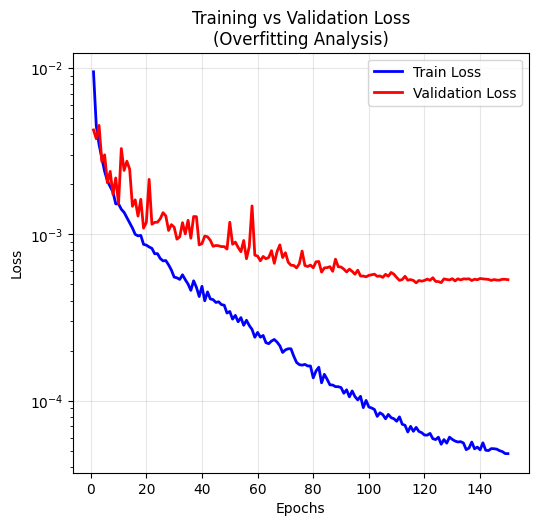

In [21]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
plt.plot(history_df['epoch'], history_df['train_loss'], 'b-', label='Train Loss', linewidth=2)
plt.plot(history_df['epoch'], history_df['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss\n(Overfitting Analysis)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log') 


### 2. RMSE Comparison

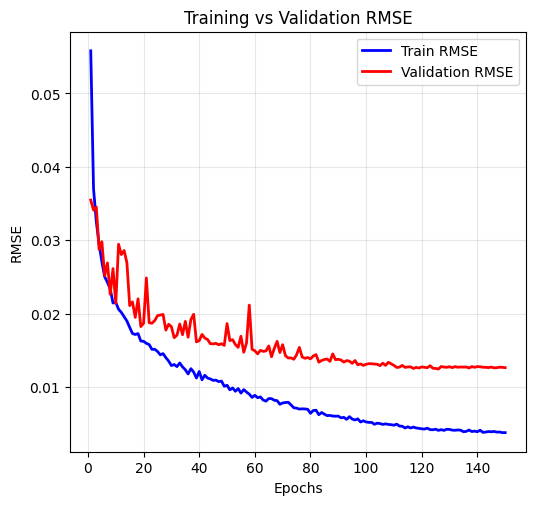

In [22]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
plt.plot(history_df['epoch'], history_df['train_rmse'], 'b-', label='Train RMSE', linewidth=2)
plt.plot(history_df['epoch'], history_df['val_rmse'], 'r-', label='Validation RMSE', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training vs Validation RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

### 3. MAE Comparison

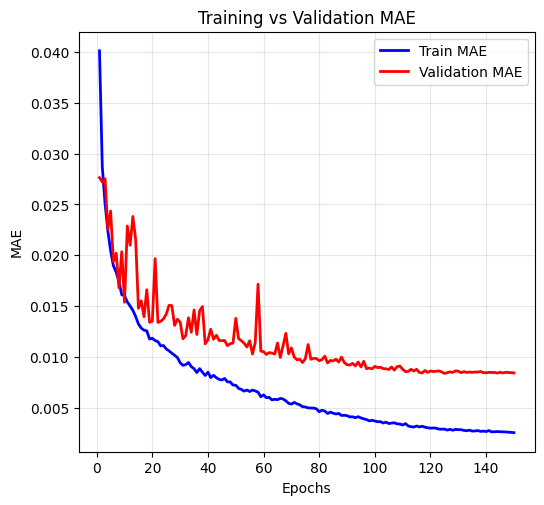

In [23]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
plt.plot(history_df['epoch'], history_df['train_mae'], 'b-', label='Train MAE', linewidth=2)
plt.plot(history_df['epoch'], history_df['val_mae'], 'r-', label='Validation MAE', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.grid(True, alpha=0.3)

### 4. R² Score Comparison

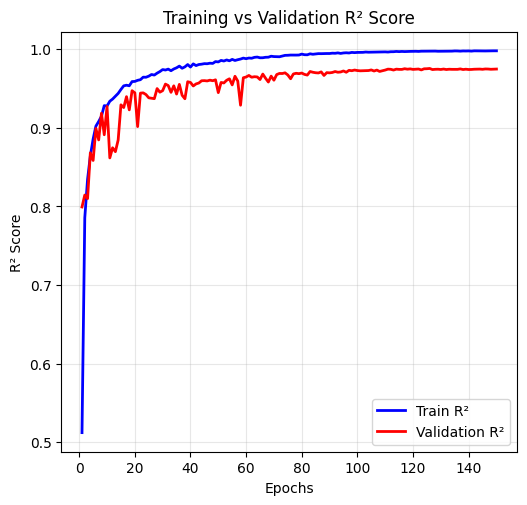

In [24]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
plt.plot(history_df['epoch'], history_df['train_r2'], 'b-', label='Train R²', linewidth=2)
plt.plot(history_df['epoch'], history_df['val_r2'], 'r-', label='Validation R²', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.title('Training vs Validation R² Score')
plt.legend()
plt.grid(True, alpha=0.3)

### 5. Learning Rate Schedule

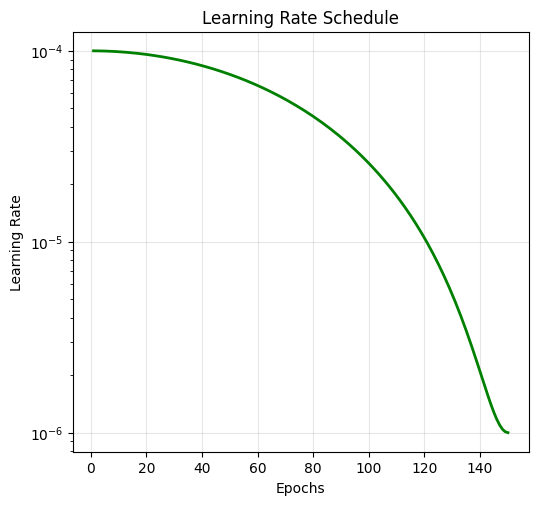

In [25]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
plt.plot(history_df['epoch'], history_df['learning_rate'], 'g-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True, alpha=0.3)
plt.yscale('log')

### 6. Gap Analysis (the gap between training and validation)

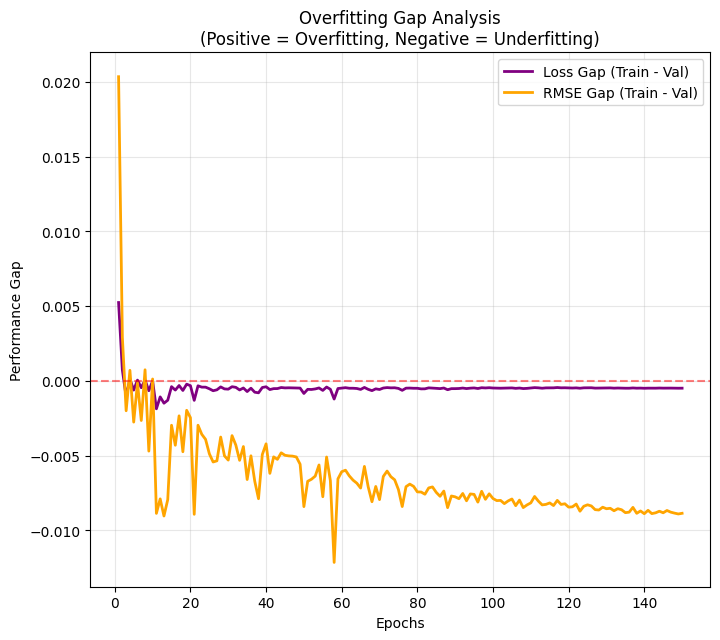

In [26]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
loss_gap = np.array(history_df['train_loss']) - np.array(history_df['val_loss'])
rmse_gap = np.array(history_df['train_rmse']) - np.array(history_df['val_rmse'])

plt.plot(history_df['epoch'], loss_gap, 'purple', label='Loss Gap (Train - Val)', linewidth=2)
plt.plot(history_df['epoch'], rmse_gap, 'orange', label='RMSE Gap (Train - Val)', linewidth=2)
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.xlabel('Epochs')
plt.ylabel('Performance Gap')
plt.title('Overfitting Gap Analysis\n(Positive = Overfitting, Negative = Underfitting)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7. Overfitting/Underfitting analysis

In [27]:
print("\n" + "="*60)
print("OVERFITTING/UNDERFITTING ANALYSIS:")
print("="*60)

final_loss_gap = history_df['train_loss'].iloc[-1] - history_df['val_loss'].iloc[-1]
final_rmse_gap = history_df['train_rmse'].iloc[-1] - history_df['val_rmse'].iloc[-1]

print(f"Final Loss Gap (Train - Val): {final_loss_gap:.4f}")
print(f"Final RMSE Gap (Train - Val): {final_rmse_gap:.4f}")

if final_loss_gap > 0.1:
    print("SIGN OF OVERFITTING: Train loss is significantly lower than validation loss")
elif final_loss_gap < -0.1:
    print("SIGN OF UNDERFITTING: Validation loss is lower than train loss")
else:
    print("GOOD FIT: Train and validation losses are well-balanced")



OVERFITTING/UNDERFITTING ANALYSIS:
Final Loss Gap (Train - Val): -0.0005
Final RMSE Gap (Train - Val): -0.0089
GOOD FIT: Train and validation losses are well-balanced


### 8. Actual vs Predicted

/tmp/ipykernel_48/426119828.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


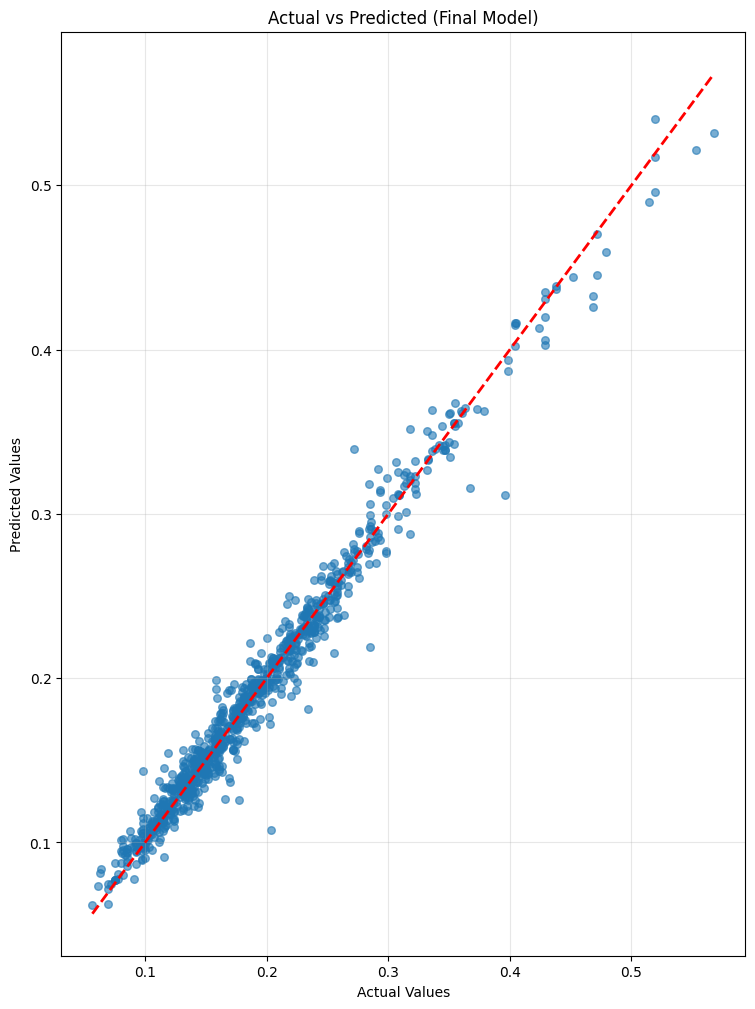

In [28]:
plt.figure(figsize=(30, 12))
plt.subplot(2, 3, 1)

# 1. Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(final_trues[:,0], final_preds[:,0], alpha=0.6, s=30)
plt.plot([final_trues[:,0].min(), final_trues[:,0].max()], [final_trues[:,0].min(), final_trues[:,0].max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Final Model)')
plt.grid(True, alpha=0.3)


### 9. Residual Plot

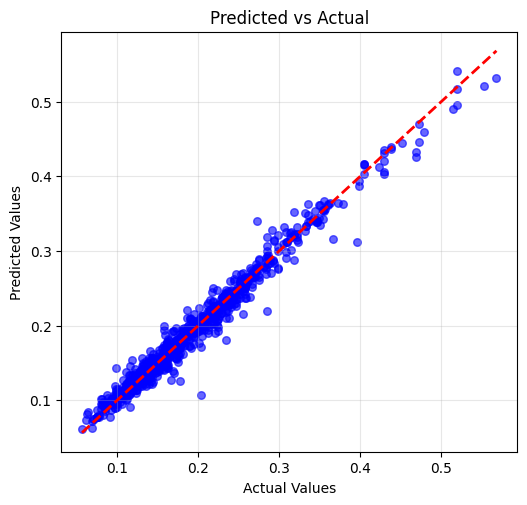

In [29]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
plt.scatter(final_trues[:,0], final_preds[:,0], alpha=0.6, s=30, color='blue')

# خط مثالي y = x
min_val = min(final_trues[:,0].min(), final_preds[:,0].min())
max_val = max(final_trues[:,0].max(), final_preds[:,0].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual')
plt.grid(True, alpha=0.3)


### 10. Residuals Distribution

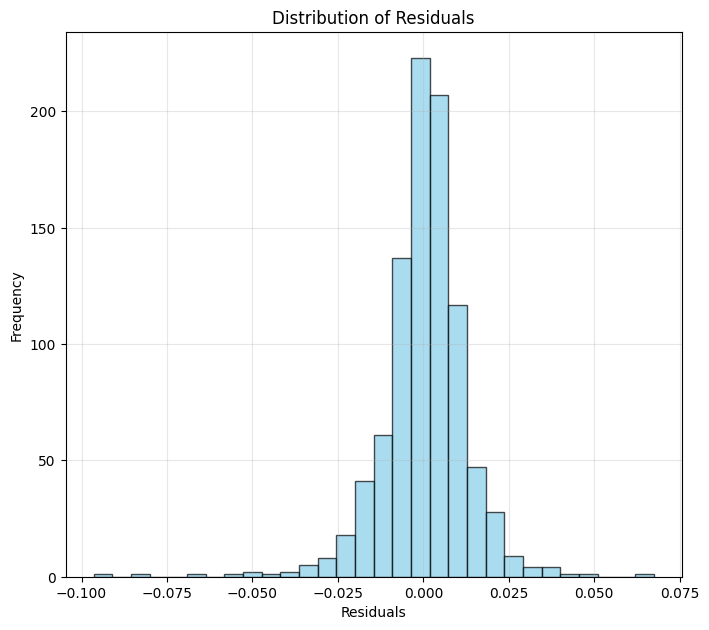


Training completed with comprehensive overfitting analysis!


In [30]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
res = final_preds[:,0] - final_trues[:,0]
plt.hist(res, bins=30, edgecolor='k', alpha=0.7, color='skyblue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTraining completed with comprehensive overfitting analysis!")

# Testing for one image 

In [31]:
img_path = "/kaggle/input/body-img/bodym_dataset/testA/mask/00e25ccd07165abbd859a16bbc569282.png"  # example
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img.astype(np.float32)/255.0
img = (img - 0.5)/0.5
img = np.transpose(img, (2,0,1))
img = torch.tensor(img).unsqueeze(0).float().to(DEVICE)

model.eval()
with torch.no_grad():
    pred = model(img).cpu().numpy().squeeze()

bodyfat_prediction = float(pred[0]) * 100
bodyfat_prediction = round(bodyfat_prediction, 2)
muscle_percentage = round(100 - bodyfat_prediction, 2)

print("Predicted Body Fat %:", bodyfat_prediction)
print("Estimated Muscle %:", muscle_percentage)

Predicted Body Fat %: 19.39
Estimated Muscle %: 80.61


# Evaluation metrics on testA and testB folders

In [32]:
def evaluate_on_test_set(test_folder, model, device, image_folder_name="mask", target_col="BodyFat_percent"):
    print(f"\n{'='*60}")
    print(f"EVALUATING ON {test_folder.upper()}")
    print(f"{'='*60}")
    
    
    test_map_path = os.path.join(base_path, test_folder, "subject_to_photo_map.csv")
    test_meas_path = os.path.join(base_path, test_folder, "measurements_with_bodyfat.csv")
    
    df_test_map = pd.read_csv(test_map_path)
    df_test_meas = pd.read_csv(test_meas_path)
    
    df_test_map = df_test_map.rename(columns={df_test_map.columns[1]: "image_name"})
        
    df_test = pd.merge(df_test_map, df_test_meas, on="subject_id", how="inner")
    
    df_test["image_name"] = df_test["image_name"].apply(lambda x: str(x) + ".png")
    df_test["image_path"] = df_test["image_name"].apply(lambda x: os.path.join(base_path, test_folder, image_folder_name, x))
   
    df_test = df_test[df_test["image_path"].apply(os.path.exists)].reset_index(drop=True)
    
    print(f" {test_folder} samples: {len(df_test)}")
    print(f"BodyFat stats - Min: {df_test[target_col].min():.2f}, Max: {df_test[target_col].max():.2f}, Mean: {df_test[target_col].mean():.2f}")
    
    
    test_transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    
    test_ds = BodyMDataset(df_test, target_col, test_transform)
    test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=0)
    
    
    model.eval()
    all_preds = []
    all_trues = []
    
    with torch.no_grad():
        for imgs, targets in tqdm(test_loader, desc=f"Testing {test_folder}"):
            imgs = imgs.to(device).float()
            targets = targets.to(device).float()
            
            outputs = model(imgs)
            all_preds.append(outputs.cpu().numpy())
            all_trues.append(targets.cpu().numpy())
    
    all_preds = np.vstack(all_preds).squeeze()
    all_trues = np.vstack(all_trues).squeeze()
    
    
    mae = mean_absolute_error(all_trues[:,0], all_preds[:,0])
    mse = mean_squared_error(all_trues[:,0], all_preds[:,0])
    rmse = np.sqrt(mse)
    r2 = r2_score(all_trues[:,0], all_preds[:,0])
    
 
    relative_error = np.mean(np.abs((all_trues[:,0] - all_preds[:,0]) / all_trues[:,0])) * 100
    
    return {
        'dataset': test_folder,
        'samples': len(df_test),
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'relative_error_percent': relative_error,
        'predictions': all_preds[:,0],
        'true_values': all_trues[:,0]
    }

In [33]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

test_results = {}
test_folders = ["testA", "testB"]

for test_folder in test_folders:
    try:
        results = evaluate_on_test_set(test_folder, model, DEVICE)
        test_results[test_folder] = results
    except Exception as e:
        print(f"Error evaluating {test_folder}: {e}")

print("\n" + "="*80)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*80)

for test_folder, results in test_results.items():
    print(f"\n {results['dataset'].upper()} RESULTS:")
    print(f"   Samples: {results['samples']}")
    print(f"   MAE: {results['mae']:.4f}")
    print(f"   RMSE: {results['rmse']:.4f}")
    print(f"   R²: {results['r2']:.4f}")
    print(f"   Relative Error: {results['relative_error_percent']:.2f}%")

# validation set
print(f"\nVALIDATION SET COMPARISON:")
print(f"   MAE: {val_mae:.4f}")
print(f"   RMSE: {val_rmse:.4f}")
print(f"   R²: {val_r2:.4f}")


EVALUATING ON TESTA
 testA samples: 1684
BodyFat stats - Min: 0.07, Max: 0.40, Mean: 0.18


Testing testA: 100%|██████████| 106/106 [00:20<00:00,  5.10it/s]



EVALUATING ON TESTB
 testB samples: 1160
BodyFat stats - Min: 0.05, Max: 0.52, Mean: 0.21


Testing testB: 100%|██████████| 73/73 [00:14<00:00,  5.19it/s]


COMPREHENSIVE EVALUATION RESULTS

 TESTA RESULTS:
   Samples: 1684
   MAE: 0.0151
   RMSE: 0.0204
   R²: 0.9280
   Relative Error: 10.18%

 TESTB RESULTS:
   Samples: 1160
   MAE: 0.0218
   RMSE: 0.0329
   R²: 0.8389
   Relative Error: 12.78%

VALIDATION SET COMPARISON:
   MAE: 0.0084
   RMSE: 0.0124
   R²: 0.9753


# Compare Actual vs Predicted

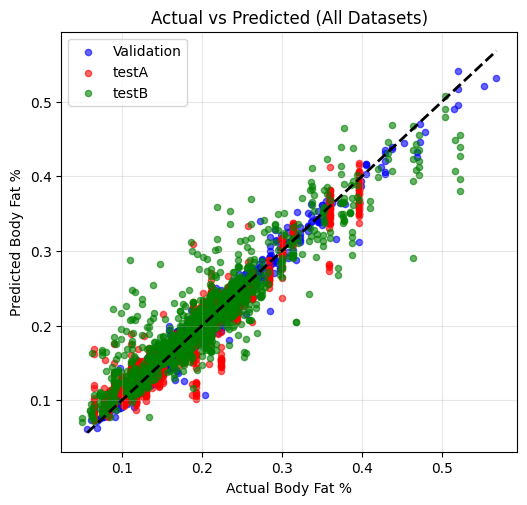

In [35]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
colors = ['blue', 'red', 'green', 'orange']
for i, (name, (trues, preds)) in enumerate(all_data.items()):
    plt.scatter(trues, preds, alpha=0.6, s=20, label=name, color=colors[i])

plt.plot([final_trues[:,0].min(), final_trues[:,0].max()], [final_trues[:,0].min(), final_trues[:,0].max()], 'k--', lw=2)
plt.xlabel('Actual Body Fat %')
plt.ylabel('Predicted Body Fat %')
plt.title('Actual vs Predicted (All Datasets)')
plt.legend()
plt.grid(True, alpha=0.3)


# MAE

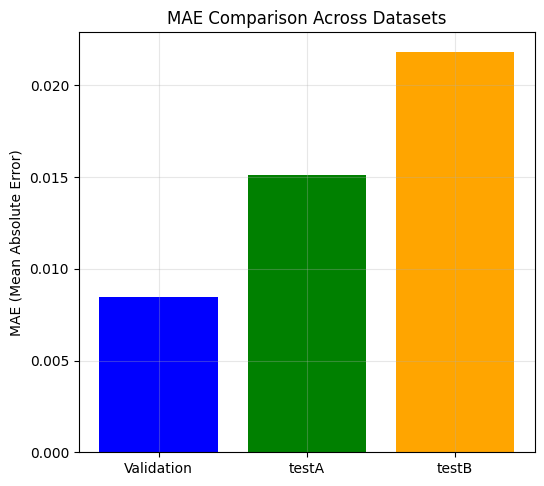

In [37]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
mae_values = [val_mae]  # Validation
mae_labels = ['Validation']

for test_folder, results in test_results.items():
    mae_values.append(results['mae'])
    mae_labels.append(test_folder)

plt.bar(mae_labels, mae_values, color=['blue', 'green', 'orange'])
plt.ylabel('MAE (Mean Absolute Error)')
plt.title('MAE Comparison Across Datasets')
plt.grid(True, alpha=0.3)


# R²

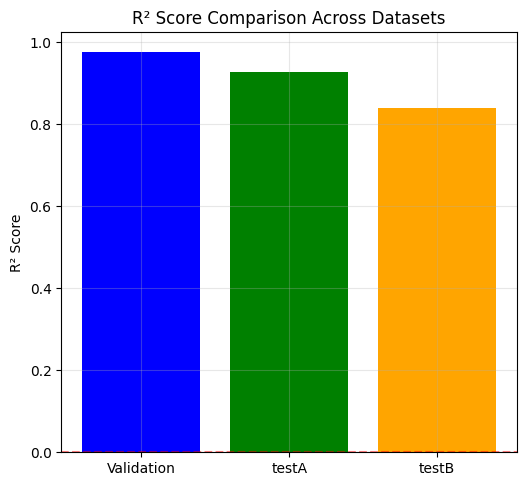

In [38]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
r2_values = [val_r2]  # Validation
r2_labels = ['Validation']

for test_folder, results in test_results.items():
    r2_values.append(results['r2'])
    r2_labels.append(test_folder)

plt.bar(r2_labels, r2_values, color=['blue', 'green', 'orange'])
plt.ylabel('R² Score')
plt.title('R² Score Comparison Across Datasets')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)


# Distribution of Actual Values

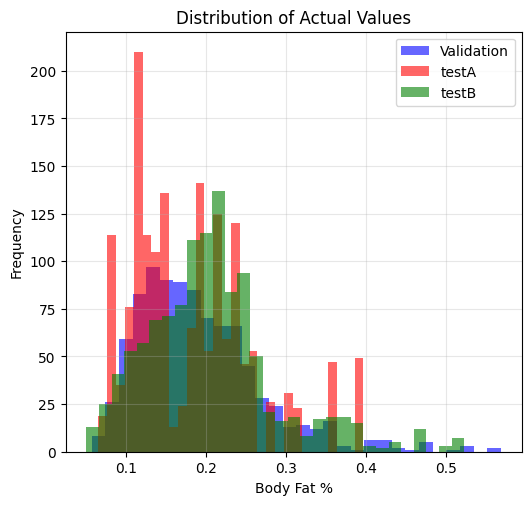

In [39]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
for i, (name, (trues, preds)) in enumerate(all_data.items()):
    plt.hist(trues, bins=30, alpha=0.6, label=name, color=colors[i])

plt.xlabel('Body Fat %')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Values')
plt.legend()
plt.grid(True, alpha=0.3)

# Table of results

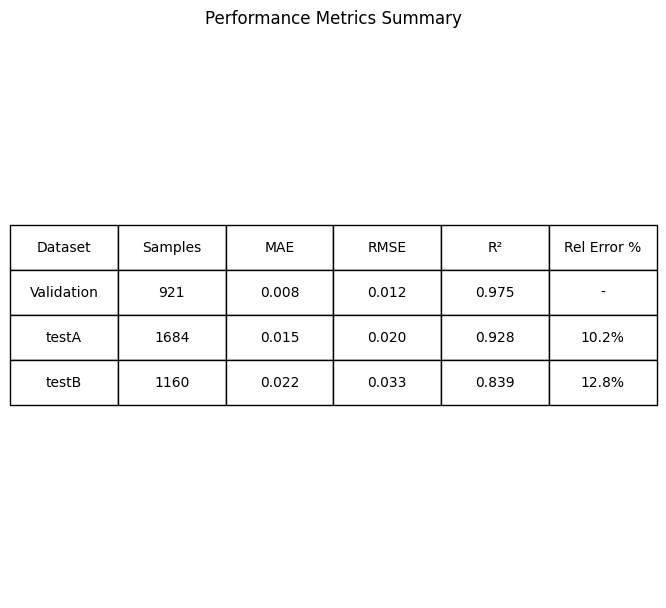

In [40]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
plt.axis('off')

# جدول النتائج
table_data = [['Dataset', 'Samples', 'MAE', 'RMSE', 'R²', 'Rel Error %']]
table_data.append(['Validation', len(final_trues), f'{val_mae:.3f}', f'{val_rmse:.3f}', f'{val_r2:.3f}', '-'])

for test_folder, results in test_results.items():
    table_data.append([
        test_folder,
        results['samples'],
        f"{results['mae']:.3f}",
        f"{results['rmse']:.3f}",
        f"{results['r2']:.3f}",
        f"{results['relative_error_percent']:.1f}%"
    ])

table = plt.table(cellText=table_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
plt.title('Performance Metrics Summary')

plt.tight_layout()
plt.show()


# JSON results

In [41]:
results_summary = {
    'validation': {
        'samples': len(final_trues),
        'mae': float(val_mae),
        'rmse': float(val_rmse),
        'r2': float(val_r2)
    },
    'test_sets': {}
}

for test_folder, results in test_results.items():
    results_summary['test_sets'][test_folder] = {
        'samples': results['samples'],
        'mae': float(results['mae']),
        'rmse': float(results['rmse']),
        'r2': float(results['r2']),
        'relative_error_percent': float(results['relative_error_percent'])
    }

with open('test_evaluation_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(" Evaluation results saved to 'test_evaluation_results.json'")
print("\n Comprehensive evaluation completed!")


 Evaluation results saved to 'test_evaluation_results.json'

 Comprehensive evaluation completed!
